# Import and format data
## These  (until *) don't need to be run

In [ ]:
import pandas as pd
# names = ['Time','ID','Data']
read_file = pd.read_csv("candump-2021-02-08_150302.log", header = None)
read_file.to_csv (r'can_data.csv', index=None)
can_data = pd.read_csv("can_data.csv")

In [ ]:
can_data

### remove vcan0

In [ ]:
text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace("vcan0", ",")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

### remove hash

In [ ]:
text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace("#", ",")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

### remove parenthesis

In [ ]:
text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace("(", "")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace(")", "")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

In [ ]:
can_data = pd.read_csv("can_data.csv",names = ['Time','ID','Data'])
can_data.to_csv (r'can_data.csv', index=None)
print(can_data)



# *

In [1]:
import pandas as pd
can_data = pd.read_csv("can_data.csv")
print(can_data)


                Time    ID              Data
0       0.000000e+00   NaN               NaN
1       1.612793e+09   039              0039
2       1.612793e+09   095  800007F400000017
3       1.612793e+09   1A4  0000000800000010
4       1.612793e+09   1AA  7FFF000000006711
...              ...   ...               ...
845498  1.612793e+09   244        00000001C0
845499  1.612793e+09   166          D0320018
845500  1.612793e+09   158  0000000000000019
845501  1.612793e+09   161  000005500108001C
845502  1.600000e+01   NaN               NaN

[845503 rows x 3 columns]


In [2]:
Time = can_data['Time']
Time = Time[1:-1]
Time = Time.reset_index(drop=True)

ID = can_data['ID']
ID = ID[1:-1]
ID = ID.reset_index(drop=True)

Data = can_data['Data']
Data = Data[1:-1]
Data = Data.reset_index(drop=True)




In [3]:
import numpy as np

def delta_time(Time): # calculates the time between two subsequent messages
    delta = np.zeros((Time.size))
    for x in range(Time.size-1):

       delta[x] = Time[x+1]-Time[x]

    return delta   

delta = delta_time(Time)


In [4]:
 def convert_from_hex(hex): # converts the data in hex from hexadecimal to decimal form
     dec = np.zeros((hex.size))

     for x in range(hex.size):
         h_value = hex[x]
         dec[x] = int(h_value,16)
     return dec


data = convert_from_hex(Data)
id = convert_from_hex(ID)

## Normalize data

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data = data.reshape(-1, 1)
data = scaler.fit_transform(data)
id = id.reshape(-1, 1)
id = scaler.fit_transform(id)

## Visualize data

Text(0, 0.5, 'ID')

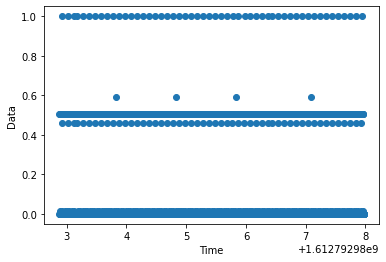

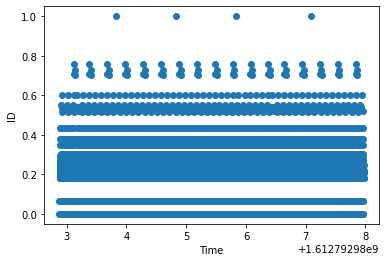

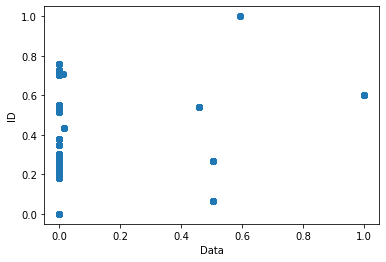

In [185]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(Time[0:10000],data[0:10000],'o')
plt.xlabel('Time')
plt.ylabel('Data')

plt.figure()
plt.plot(Time[0:10000],id[0:10000],'o')
plt.xlabel('Time')
plt.ylabel('ID')

plt.figure()
plt.plot(data[0:10000],id[0:10000],'o')
plt.xlabel('Data')
plt.ylabel('ID')




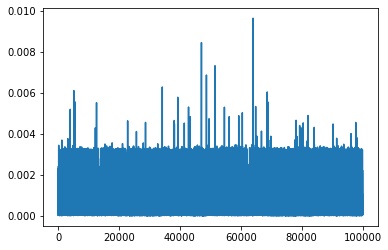

In [6]:
steps = range(Time.size)
plt.figure()
plt.plot(steps[0:100000],delta[0:100000])

In [6]:
def sort_IDs(id): # returns groups of indices of unique ids in list 

    idx_sort = np.argsort(id)
    sorted_ids = id[idx_sort]
    vals, idx_start, count = np.unique(sorted_ids, return_counts=True, return_index=True)
    indices = np.split(idx_sort, idx_start[1:])

    return indices





In [233]:
transposed_id = np.transpose(id) # not sure why it needs to be transposed but it doesn't work otherwise
indices = sort_IDs(transposed_id[0][:])




In [122]:
def get_data_stream(indices,data): # collects the unique ids with their respective data streams

    num_unique_ids = len(indices)
    all_ids = []
    for x in range(num_unique_ids):
         
         id_data = data[indices[x]]
         all_ids.append(id_data)

    return all_ids

all_id_data = get_data_stream(indices,data)  

In [123]:
 # combines each unique id with its data stream in a matrix where the ID is in the first row, and its data stream is (ordered)
 # in the column under it. (one column = ID: data1,data2,..). column length = max data length, if data doesn't fill upp all rows they are filled with nan. 
def combine_ids_data(indices,id,all_id_data):
    i = -1
    ids_and_data = np.ones((np.max([len(pi) for pi in all_id_data])+1,len(all_id_data)))*np.nan 

    for x in indices:
        i = i+ 1
        index = indices[i] 
        index = index[0] # only save first one in group
        ID = id[index]

        data_stream = all_id_data[i]
        data_stream = data_stream[:,0] 
        ids_and_data[0,i] = ID
        ids_and_data[1:len(data_stream)+1,i] = data_stream

    return ids_and_data

d = combine_ids_data(indices,id,all_id_data)

In [146]:

print(f'Number of individual IDs in the full sequence = {len(d[0,:])}')
print(f'Maximum number of data packets per ID = {np.max([len(pi) for pi in all_id_data])}')

Number of individual IDs in the full sequence = 36
Maximum number of data packets per ID = 43061


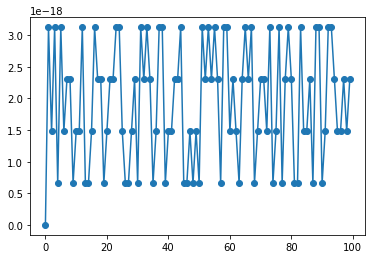

In [245]:
plt.plot(np.arange(100),d[0:100,0],'-o')

# Copied

In [117]:
# split a univariate sequence into samples
from numpy import array


def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [246]:
from numpy import array


def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
		# find the end of this pattern
        end_ix = i + n_steps
        end_iy = end_ix + n_steps 
		# check if we are beyond the sequence
        if end_iy > len(sequence)-1:
            break
		# gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_iy]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [247]:
n_steps = 5
X, y = split_sequence(d[:,0], n_steps)



In [248]:
print(f'x = {X}')
print(f'y= {y}')

x = [[0.00000000e+00 3.12656852e-18 1.48100614e-18 3.12656852e-18
  6.58224951e-19]
 [3.12656852e-18 1.48100614e-18 3.12656852e-18 6.58224951e-19
  3.12656852e-18]
 [1.48100614e-18 3.12656852e-18 6.58224951e-19 3.12656852e-18
  1.48100614e-18]
 ...
 [           nan            nan            nan            nan
             nan]
 [           nan            nan            nan            nan
             nan]
 [           nan            nan            nan            nan
             nan]]
y= [[3.12656852e-18 1.48100614e-18 2.30378733e-18 2.30378733e-18
  6.58224951e-19]
 [1.48100614e-18 2.30378733e-18 2.30378733e-18 6.58224951e-19
  1.48100614e-18]
 [2.30378733e-18 2.30378733e-18 6.58224951e-19 1.48100614e-18
  1.48100614e-18]
 ...
 [           nan            nan            nan            nan
             nan]
 [           nan            nan            nan            nan
             nan]
 [           nan            nan            nan            nan
             nan]]


In [251]:

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

  Using cached tensorflow-2.4.1-cp38-cp38-win_amd64.whl (370.7 MB)
  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=19558 sha256=16994d4da6242ff354141c7eb4ca114afc758e84b98eeb4cb5b56145df830720
  Stored in directory: c:\users\ellsan\appdata\local\pip\cache\wheels\5f\fd\9e\b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=ad36b44462286344fa5350304ddf9c285ec623f92c22e6644fe5d504e8cd33e3
  Stored in directory: c:\users\ellsan\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built wrapt termcolor
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.11.2
    Uninstalling wrapt-1.11.2:
      Successfully uninstalled wrapt-1.11.2
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppr

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [253]:
! pip list

Package                            Version
---------------------------------- -------------------
absl-py                            0.11.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.4.2
astropy                            4.0.2
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
backports.weakref                  1.0.post1
bcrypt                            

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model

model.fit(X, y, epochs=20, verbose=0)

In [ ]:

# demonstrate prediction
x_input = X[50:55,1,:]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

In [ ]:
print( X[56,1,:]-yhat)
print( X[56,1,:])

In [ ]:
train_X = X
train_y = y
test_X = X[50:55,1,:]
test_y = X[56,1,:]
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## ^copied